# Beta Variational Autoencoder (simple dots)

In this notebook, we will use a beta variational autoencoder ($\beta$-VAE) to encode/decode a simple dataset consisting of a single white dot on a black background.
The $\beta$ term is varied to explore it's impact on reconstruction and latent representation.

## Setup

In [1]:
import sconce
print(f"This notebook was run using sconce {sconce.__version__}")

This notebook was run using sconce 1.2.1


### Define plot_traversal function

We'll make extensive use of this function to explore the latent representations encoded by our $\beta$-VAEs.
This function takes and encodes a single input image, and then shows how varying each latent variable
affects the reconstruction.
Burgess et. al. describe latent traversals in figure 2 [here](http://arxiv.org/abs/1804.03599).

In [2]:
from matplotlib import pyplot as plt
import numpy as np

def plot_traversal(trainer, index=0, figure_width=10.5, num_cols=9, image_height=1.5):
    """
    Plot a traversal of the latent space.
    
    Steps are:
        1) encode an input to a latent representation
        2) adjust each latent value from -3 to 3 while keeping other values fixed
        3) decode each adjusted latent representation
        4) display
    """
    sample, target = trainer.validation_feed.dataset[index]
    sample_batch = sample[None].cuda()
    trainer.model.train(False)
    mu, logvar = trainer.model.encode(sample_batch)
    z = mu  # since we're not training, no noise is added
    
    num_rows = z.shape[-1]
    num_cols = num_cols
    
    fig = plt.figure(figsize=(figure_width, image_height * num_rows))
    
    for i in range(num_rows):
        z_i_values = np.linspace(-3.0, 3.0, num_cols)
        z_i = z[0][i].detach().cpu().numpy()
        z_diffs = np.abs((z_i_values - z_i))
        j_min = np.argmin(z_diffs)
        for j in range(num_cols):
            z_i_value = z_i_values[j]
            if j != j_min:
                z[0][i] = z_i_value
            else:
                z[0][i] = float(z_i)
                
            x = trainer.model.decode(z).detach().cpu().numpy()
            
            ax = fig.add_subplot(num_rows, num_cols, i * num_cols + j + 1)
            ax.imshow(x[0][0], cmap='gray')
            
            if i == 0 or j == j_min:
                ax.set_title(f'{z[0][i]:.1f}')
            
            if j == j_min:
                ax.set_xticks([], [])
                ax.set_yticks([], []) 
                color = 'mediumseagreen'
                width = 8
                for side in ['top', 'bottom', 'left', 'right']:
                    ax.spines[side].set_color(color)
                    ax.spines[side].set_linewidth(width)
            else:
                ax.axis('off')
        z[0][i] = float(z_i)
        
    plt.tight_layout()
    fig.subplots_adjust(wspace=0.04)

In [3]:
from sconce.data_feeds import ImageFeed
from sconce.datasets import SimpleDots

dataset = SimpleDots(image_size=(62, 62), circle_radius=8, num_images=3_000)
training_feed = ImageFeed.from_dataset(dataset, batch_size=100, num_workers=0, shuffle=True)

In [4]:
import torch
from torch import optim
from sconce.trainers import AutoencoderTrainer
from sconce.models import VariationalAutoencoder

def get_trainer(conv_channels=[32, 32, 32], hidden_sizes=[256, 256], latent_size=5):
    model = VariationalAutoencoder(conv_channels=conv_channels,
                                   hidden_sizes=hidden_sizes,
                                   image_channels=1,
                                   image_size=dataset.image_size,
                                   latent_size=latent_size)
    
    if torch.cuda.is_available():
        model.cuda()
        training_feed.cuda()
        
    model.set_optimizer(optim.SGD, lr=1e-4, momentum=0.9, weight_decay=1e-4)

    trainer = AutoencoderTrainer(model=model,
        training_feed=training_feed,
        validation_feed=training_feed)
    trainer.validation_to_train_ratio = 0
    return trainer

## Results (Critical Beta Value)

231/297 [======================>.......] - ETA: 1s - loss: 0.2386
Scheduled training termination: Exponential Schedule stop condition met.


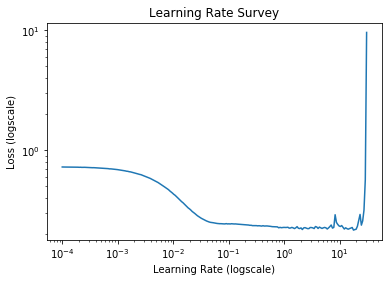

In [5]:
trainer = get_trainer()
trainer.model.set_schedule('beta', 0.13)
survey_monitor = trainer.survey_learning_rate(
    num_epochs=10,
    min_learning_rate=1e-4,
    max_learning_rate=1e3,
    stop_factor=10)
survey_monitor.dataframe_monitor.plot_learning_rate_survey();

2970/2970 [==============================] - 47s 16ms/step - loss: 0.1564


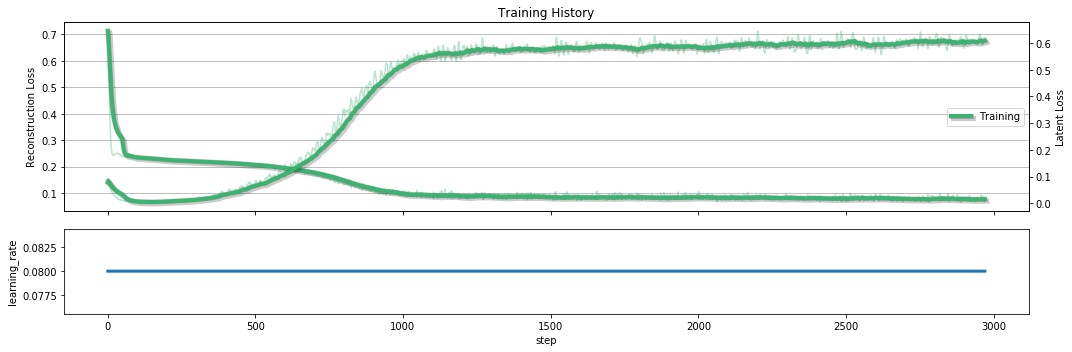

In [6]:
trainer.model.set_schedule('learning_rate', 8e-2)
trainer.model.set_schedule('beta', 0.13)
monitor = trainer.train(num_epochs=100)
monitor.dataframe_monitor.plot(skip_first=0, metrics=['reconstruction_loss', 'latent_loss']);

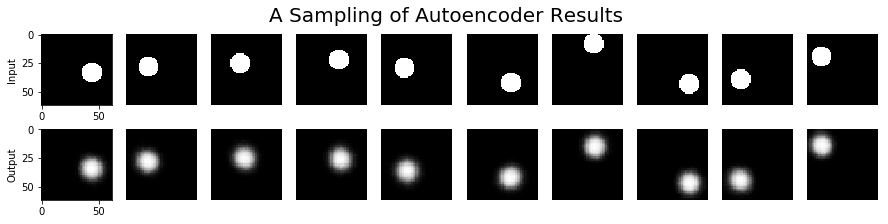

In [7]:
trainer.plot_input_output_pairs();

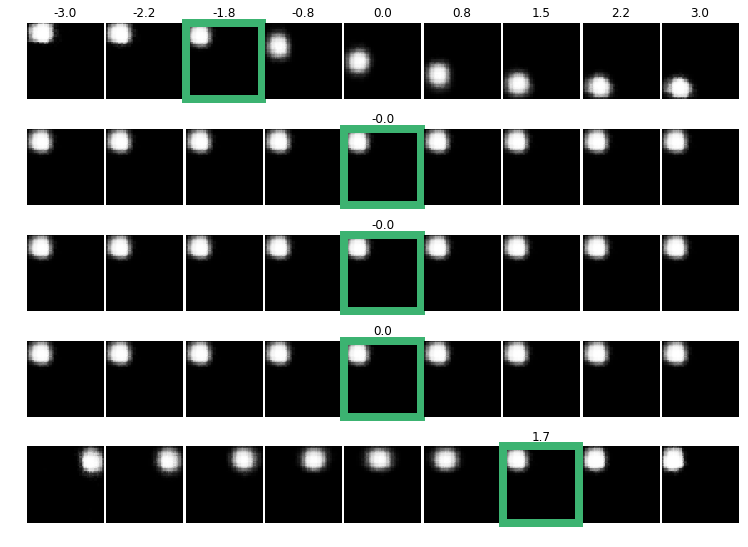

In [8]:
plot_traversal(trainer)

## Results (High Beta Value)

2970/2970 [==============================] - 48s 16ms/step - loss: 0.2028


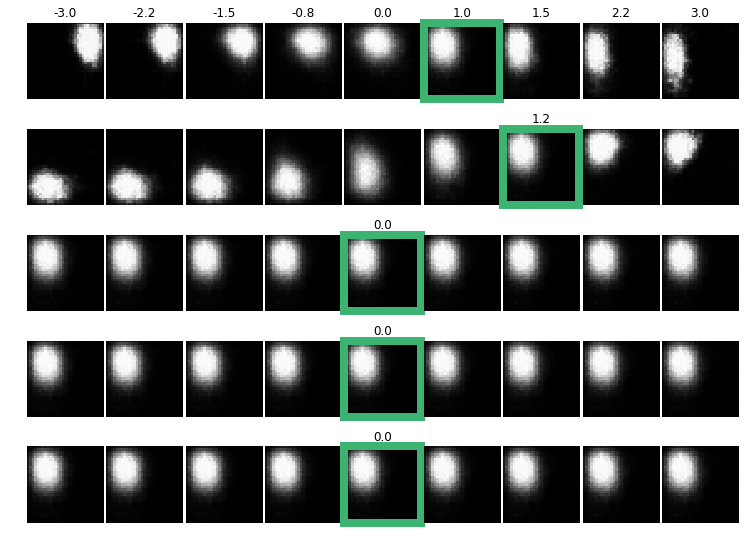

In [9]:
trainer = get_trainer()
trainer.model.set_schedule('learning_rate', 8e-2)
trainer.model.set_schedule('beta', 0.20)
trainer.train(num_epochs=100)
plot_traversal(trainer)

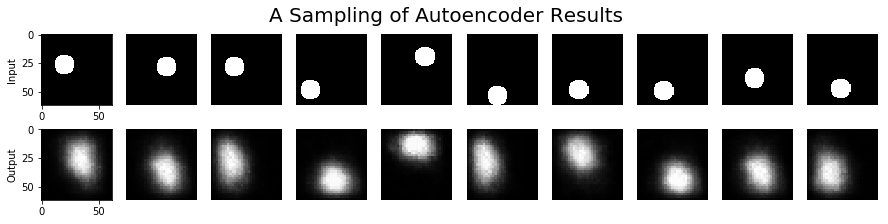

In [10]:
trainer.plot_input_output_pairs();

## Results (Low Beta Value)

2970/2970 [==============================] - 48s 16ms/step - loss: 0.0132


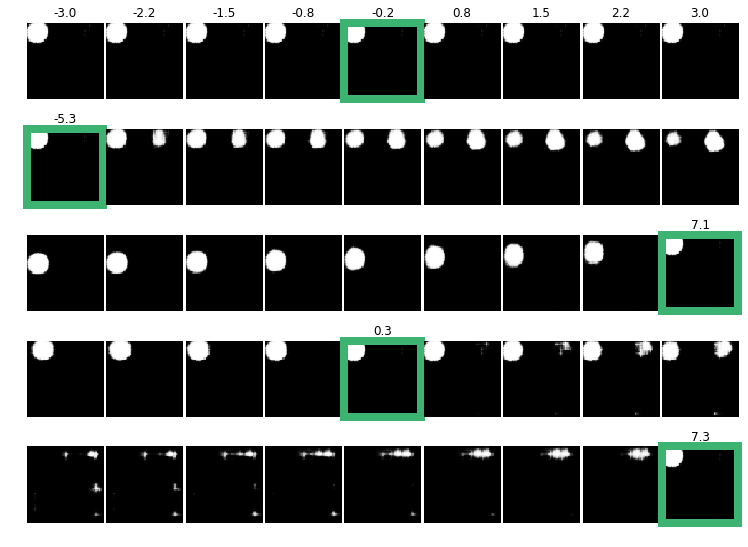

In [11]:
trainer = get_trainer()
trainer.model.set_schedule('learning_rate', 8e-2)
trainer.model.set_schedule('beta', 1e-4)
trainer.train(num_epochs=100)
plot_traversal(trainer)

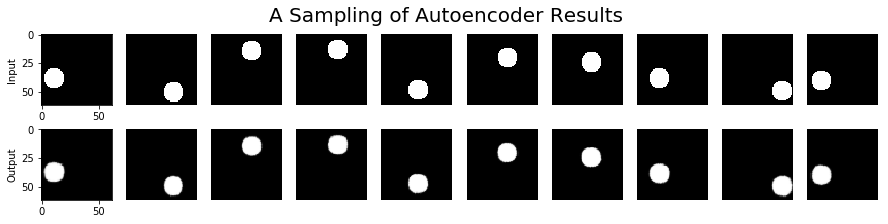

In [12]:
trainer.plot_input_output_pairs();

## Adjusting beta during training

In [13]:
from sconce.schedules import Triangle

trainer = get_trainer()
trainer.model.set_schedule('learning_rate', 8e-2)
trainer.model.set_schedule('beta', Triangle(initial_value=1e-3, peak_value=0.3))
trainer.train(num_epochs=200)

5940/5940 [==============================] - 95s 16ms/step - loss: 0.0414


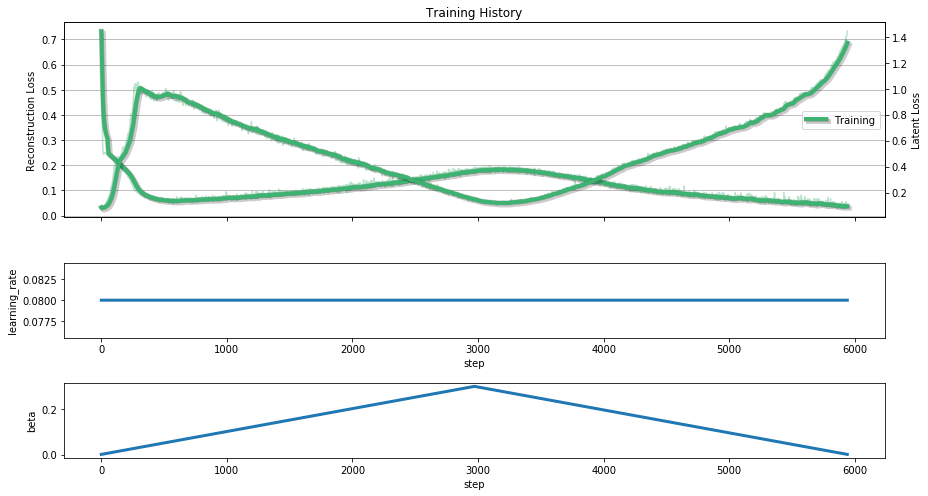

In [14]:
trainer.monitor.dataframe_monitor.plot(figsize=(13, 7), skip_first=0,
                               metrics=['reconstruction_loss', 'latent_loss'],
                               hyperparameters=[{'name': 'learning_rate'},
                                                {'name': 'beta'}]
                              );

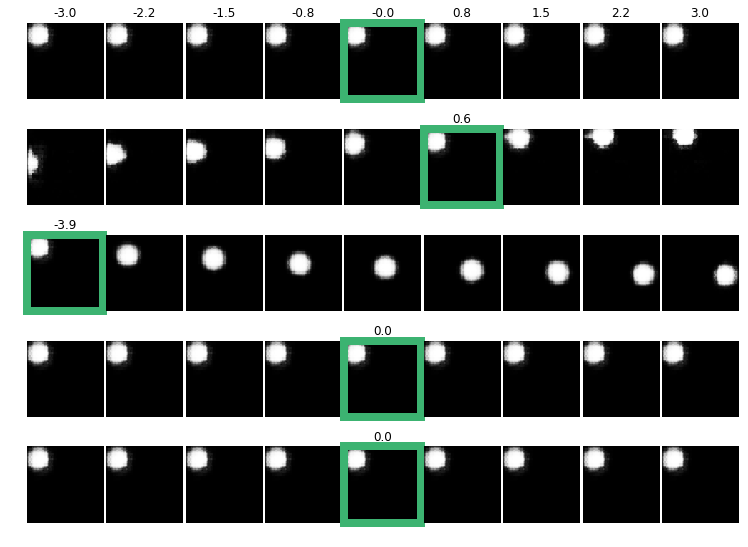

In [15]:
plot_traversal(trainer)

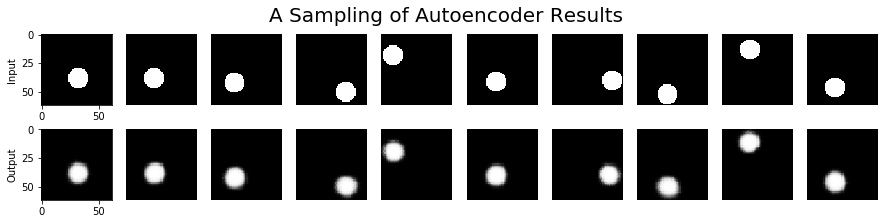

In [16]:
trainer.plot_input_output_pairs();